In [60]:
import glob
import os
from os.path import isfile, join
from tqdm import tqdm
import matplotlib.pyplot as plt
from elasticsearch import Elasticsearch, helpers
from spacy.lang.pl import Polish
from spacy.tokenizer import Tokenizer
import datetime
import Levenshtein as lvs
import pandas as pd
import morfeusz2
import regex as re
import tarfile
import numpy as np
import glob
import spacy
from collections import defaultdict
import json
from datetime import datetime
from math import log

In [79]:
NER_PATH = "NER"
LAB5_PATH = "tag_lem_lab5"

## 4. Sort bills according to their size and take top 50 (largest) bills.

In [6]:
bills = []

for file in glob.glob("*.txt"):
    with open(os.getcwd() + "/" + file, 'r', encoding='utf-8') as f:
        bill = f.read()
        bills.append((bill, len(bill)))

In [10]:
bills_lengths = [x[1] for x in bills]
bills_lengths.sort(reverse=True)

In [11]:
list(enumerate(bills_lengths))

[(0, 560054),
 (1, 397912),
 (2, 396433),
 (3, 377867),
 (4, 335096),
 (5, 263259),
 (6, 260926),
 (7, 251625),
 (8, 247419),
 (9, 246943),
 (10, 246472),
 (11, 242040),
 (12, 240315),
 (13, 236092),
 (14, 234368),
 (15, 228908),
 (16, 225491),
 (17, 225365),
 (18, 222863),
 (19, 222773),
 (20, 220416),
 (21, 216250),
 (22, 208967),
 (23, 208139),
 (24, 208090),
 (25, 203106),
 (26, 182339),
 (27, 181052),
 (28, 176119),
 (29, 174921),
 (30, 174226),
 (31, 173335),
 (32, 171460),
 (33, 170495),
 (34, 168574),
 (35, 168129),
 (36, 162698),
 (37, 156259),
 (38, 155527),
 (39, 148137),
 (40, 146672),
 (41, 144573),
 (42, 144363),
 (43, 142416),
 (44, 141409),
 (45, 138946),
 (46, 137170),
 (47, 136040),
 (48, 131863),
 (49, 129257),
 (50, 128635),
 (51, 124983),
 (52, 124056),
 (53, 122320),
 (54, 122277),
 (55, 120882),
 (56, 120318),
 (57, 120065),
 (58, 117926),
 (59, 117071),
 (60, 116848),
 (61, 116775),
 (62, 115507),
 (63, 113121),
 (64, 112966),
 (65, 108153),
 (66, 107302),
 (67,

In [13]:
bills_top50 = list(map(lambda x: x[0], filter(lambda x: x[1] >= bills_lengths[49], bills)))

In [36]:
bills_top50[0]

'\n\n\n\n \n                                        \n                                                                             \n                                        \n                                        \n                                        \n                                     USTAWA\n                            z dnia 30 czerwca 2000 r.\n                                        \n                          Prawo własności przemysłowej\n                                        \n                                     Tytuł I\n                                 Przepisy ogólne\n                                        \n                                     Art. 1.\n1. Ustawa normuje:\n   1) stosunki w zakresie wynalazków, wzorów użytkowych, wzorów przemysłowych,\n     znaków towarowych, oznaczeń geograficznych i topografii układów scalonych,\n   2) zasady, na jakich przedsiębiorcy mogą przyjmować projekty\n     racjonalizatorskie i wynagradzać ich twórców,\n   3) zadania i org

## 5. Use the lemmatized and sentence split documents (from ex. 5) to identify the expressions that consist of consecutive words starting with a capital letter (you will have to look at the inflected form of the word to check its capitalization) that do not occupy the first position in a sentence. E.g. the sentence:
### - Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych.
## should yield the following entries: Kraków, Polska, Stan Zjednoczony.

In [49]:
files_list = []
files = [f for f in os.listdir(LAB5_PATH) if isfile(join(LAB5_PATH, f))]

for file in files:
    with open(join(LAB5_PATH, file), 'r', encoding='utf-8') as f:
        files_list.append((file, json.load(f)))

In [52]:
files_list[0][1]

[['dziennik', 'brev:pun'],
 ['.', 'interp'],
 ['ustawa', 'brev:pun'],
 ['.', 'interp'],
 ['z', 'prep:gen:nwok'],
 ['1993', 'adj:sg:gen:m3:pos'],
 ['rok', 'brev:pun'],
 ['.', 'interp'],
 ['numer', 'brev:npun'],
 ['129', 'num:pl:nom:m3:rec'],
 [',', 'interp'],
 ['pozycja', 'brev:pun'],
 ['.', 'interp'],
 ['599', 'adj:sg:nom:f:pos'],
 ['ustawa', 'subst:sg:nom:f'],
 ['z', 'prep:gen:nwok'],
 ['dzień', 'subst:sg:gen:m3'],
 ['9', 'adj:sg:gen:m3:pos'],
 ['grudzień', 'subst:sg:gen:m3'],
 ['1993', 'adj:sg:gen:m3:pos'],
 ['rok', 'brev:pun'],
 ['.', 'interp'],
 ['o', 'prep:loc'],
 ['zmiana', 'subst:sg:loc:f'],
 ['ustawa', 'subst:sg:gen:f'],
 ['o', 'prep:loc'],
 ['podatek', 'subst:sg:loc:m3'],
 ['od', 'prep:gen:nwok'],
 ['towar', 'subst:pl:gen:m3'],
 ['i', 'conj'],
 ['usługa', 'subst:pl:gen:f'],
 ['oraz', 'conj'],
 ['o', 'prep:loc'],
 ['podatek', 'subst:sg:loc:m3'],
 ['akcyzowy', 'adj:sg:loc:m3:pos'],
 ['artykuł', 'brev:pun'],
 ['.', 'interp'],
 ['1', 'adj:sg:loc:m3:pos'],
 ['.', 'interp'],
 ['w', 

In [62]:
entries_regex = "\p{L}*$"

In [61]:
exercise_sentence = "Wczoraj w Krakowie miało miejsce spotkanie prezydentów Polski i Stanów Zjednoczonych ."
exercise_tokens = [(word, 'placeholder') for word in exercise_sentence.split()]

In [63]:
def get_capital_sentences(bill):
    cap_words = defaultdict(int)
    for i in range(0,len(bill)-1):
        if bill[i-1][0] != '.' and bill[i][0][0].isupper() and re.match(entries_regex, bill[i][0]):
            cap_words[bill[i][0]] += 1
    return cap_words

In [64]:
get_capital_sentences(exercise_tokens)

defaultdict(int, {'Krakowie': 1, 'Polski': 1, 'Stanów': 1, 'Zjednoczonych': 1})

In [67]:
get_capital_sentences(files_list[0][1])

defaultdict(int,
            {'Warszawa': 1,
             'Śródmieście': 1,
             'É': 1,
             'Â': 2,
             'Poz': 3,
             'SWW': 14,
             'Ă': 2,
             'Ĺ': 4,
             'Č': 1,
             'Á': 2,
             'Rzeczpospolita': 1,
             'Y': 2,
             'K': 2,
             'II': 2,
             'Braille': 1,
             'III': 2,
             'I': 1,
             'IV': 1,
             'CIA': 1,
             'V': 1,
             'VI': 1,
             'Rozdzielnice': 1,
             'Kamionka': 2,
             'KOB': 3})

In [69]:
get_capital_sentences(files_list[5][1])

defaultdict(int,
            {'Rzeczpospolita': 43,
             'Polska': 12,
             'II': 8,
             'I': 7,
             'Art': 7,
             'III': 5,
             'IV': 2,
             'R': 1,
             'G': 1,
             'T': 1,
             'V': 1,
             'VI': 1,
             'VII': 1,
             'VIII': 1,
             'IX': 1,
             'X': 1,
             'XI': 1})

## 6. Compute the frequency of each identified expression and print 50 results with the largest number of occurrences.

In [ ]:
#Całościowe nazwy, nawet z wielu słów - pełne sekwencje zaczynające się dużymi literami

In [73]:
cap_occurences = defaultdict(int)
for bill in files_list:
    new_occurences = get_capital_sentences(bill[1])
    cap_occurences = {k: cap_occurences.get(k, 0) + new_occurences.get(k, 0) for k in set(cap_occurences) | set(new_occurences)}

total_counts = sum([len(bill[1]) for bill in files_list])

In [75]:
top50 = sorted(cap_occurences, key=cap_occurences.get, reverse=True)[:50]

In [76]:
[(word, cap_occurences[word], cap_occurences[word]/total_counts) for word in top50]

[('Rzeczpospolita', 3629, 0.0006882572204422067),
 ('Art', 1182, 0.0002241719577191205),
 ('Polska', 660, 0.00012517215913250383),
 ('I', 560, 0.00010620668047606386),
 ('II', 518, 9.824117944035907e-05),
 ('L', 403, 7.643087898545309e-05),
 ('Warszawa', 370, 7.017227102882791e-05),
 ('III', 365, 6.922399709600591e-05),
 ('WE', 298, 5.651712639619112e-05),
 ('GMO', 298, 5.651712639619112e-05),
 ('A', 293, 5.556885246336913e-05),
 ('SA', 262, 4.9689554079872734e-05),
 ('PKP', 244, 4.6275767921713536e-05),
 ('PESEL', 243, 4.6086113135149136e-05),
 ('Republika', 241, 4.570680356202034e-05),
 ('EWG', 235, 4.456887484263394e-05),
 ('IV', 231, 4.381025569637634e-05),
 ('SWW', 227, 4.3051636550118746e-05),
 ('B', 218, 4.1344743471039144e-05),
 ('EFTA', 204, 3.868957645913755e-05),
 ('SKW', 196, 3.717233816662235e-05),
 ('S', 194, 3.679302859349355e-05),
 ('NBP', 185, 3.5086135514413956e-05),
 ('BOR', 172, 3.262062328907676e-05),
 ('IKE', 161, 3.053442063686836e-05),
 ('V', 136, 2.579305097275

## 8. Plot the frequency (histogram) of the coarse-grained classes (e.g. nam_adj, nam_eve, nam_fac).

In [80]:
import xml.etree.ElementTree as ET

In [ ]:
# files_list = []
# files = [f for f in os.listdir(LAB5_PATH) if isfile(join(LAB5_PATH, f))]

# for file in files:
#     with open(join(LAB5_PATH, file), 'r', encoding='utf-8') as f:
#         files_list.append((file, json.load(f)))

In [81]:
ner_files_list = []
ner_files = [f for f in os.listdir(NER_PATH) if isfile(join(NER_PATH, f))]

for file in ner_files:
    ner_files_list.append((file, ET.parse(join(NER_PATH, file))))

In [83]:
coarse_grained_count = defaultdict(int)
for data in ner_files_list:
    root = data[1].getroot()
    for chunk in root:
        for sentence in chunk:
            for token in sentence:
                for child in token:
                    if child.tag == 'ann' and int(child.text) > 0:
                        coarse_grained_count['_'.join(child.attrib["chan"].split("_")[0:2])] += 1

In [84]:
coarse_grained_count

defaultdict(int,
            {'nam_org': 28597,
             'nam_loc': 2592,
             'nam_pro': 16495,
             'nam_adj': 383,
             'nam_liv': 1117,
             'nam_oth': 726,
             'nam_fac': 348,
             'nam_eve': 73,
             'nam_num': 14})

In [85]:
coarse_grained_freq = {k: v/total_counts for k, v in coarse_grained_count.items()}

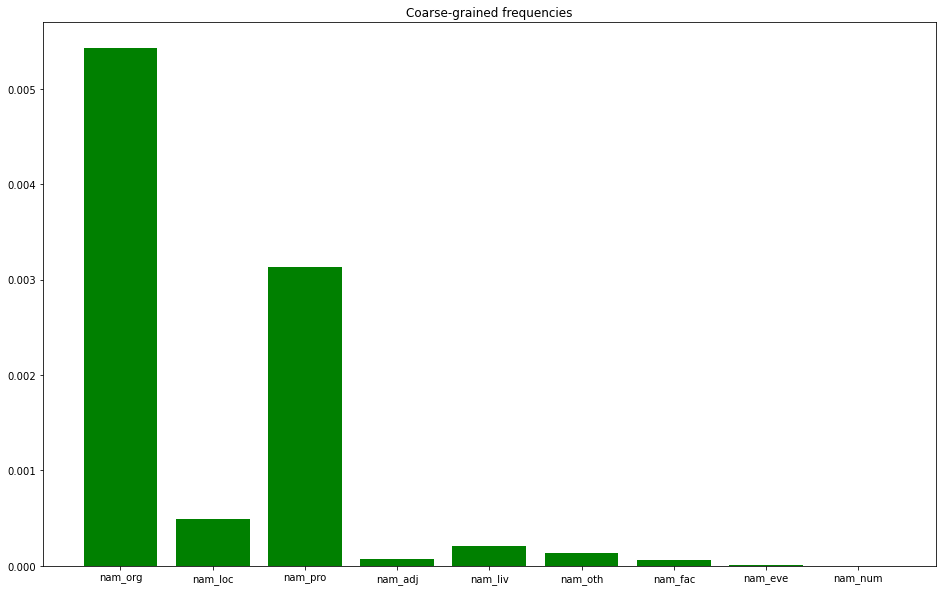

In [91]:
plt.figure(figsize=(16,10))
plt.bar(coarse_grained_freq.keys(), coarse_grained_freq.values(), color='g')
plt.title("Coarse-grained frequencies")
plt.show()

## 9. Display 10 most frequent Named Entities for each coarse-grained type.

In [93]:
tokens_counts = defaultdict(int)
for data in ner_files_list:
    root = data[1].getroot()
    for chunk in root:
        for sentence in chunk:
            for token in sentence:
                for child in token:
                    if child.tag == 'ann' and int(child.text) > 0:
                        tokens_counts[(token[0].text, '_'.join(child.attrib["chan"].split("_")[0:2]), child.attrib["chan"])] += 1

In [94]:
coarse_grained = ['nam_org', 'nam_loc', 'nam_pro', 'nam_adj', 'nam_liv', 'nam_oth', 'nam_fac', 'nam_eve', 'nam_num']

In [98]:
for category in coarse_grained:
    occurrences = {k[0]: v for k, v in tokens_counts.items() if k[1] == category}
    highest_occurences = sorted(occurrences, key=occurrences.get, reverse=True)[:10]
    print("\033[1m" + category + "\033[0m")
    for word in highest_occurences:
        print(word + " : " + str(occurrences[word]))
    print('-'*50)

nam_org
Państwa : 704
Ministrów : 653
Skarbu : 353
Narodowej : 339
Komisji : 312
Spraw : 253
Finansów : 246
Ministra : 225
Państwowej : 214
Ministrem : 213
--------------------------------------------------
nam_loc
Rzeczypospolitej : 813
Polska : 54
Rzeczpospolita : 52
Polską : 52
Polsce : 51
Rzeczpospolitą : 39
Warszawie : 32
Republiki : 25
Warszawy : 20
Nawóz : 19
--------------------------------------------------
nam_pro
Dz : 1638
U : 1545
o : 707
dnia : 581
r : 566
ustawie : 321
ustawy : 280
postępowania : 135
karnego : 118
Prawo : 101
--------------------------------------------------
nam_adj
polski : 116
polskiej : 30
polskiego : 16
Wojewódzki : 16
polskim : 10
polska : 9
polską : 7
polskich : 7
mazowiecki : 7
europejskiej : 5
--------------------------------------------------
nam_liv
Chorych : 113
Kasa : 55
Straży : 36
Granicznej : 36
Zbrojnych : 29
Gospodarki : 27
Sił : 27
Kasy : 25
Krajowego : 23
. : 20
--------------------------------------------------
nam_oth
zł : 293
- : 13

## 10. Display 50 most frequent Named Entities including their count and fine-grained type.

In [100]:
sorted_counts = {k: v for k, v in sorted(tokens_counts.items(), key=lambda item: -item[1])}
highest_counts = list(sorted_counts.items())[:50]
counts_df = pd.DataFrame(highest_counts, columns=['token', 'count'])
split_df = pd.DataFrame(counts_df['token'].tolist(), columns=['word', 'shush', 'type'])
counts_df = pd.concat([split_df, counts_df], axis=1)
counts_df = counts_df.drop(labels=['token', 'shush'], axis=1)

In [101]:
counts_df

,word,type,count
0,.,nam_pro_media_periodic,3167
1,Dz,nam_pro_media_periodic,1638
2,U,nam_pro_media_periodic,1545
3,Urzędu,nam_org_institution,886
4,Polskiej,nam_loc_gpe_country,815
5,Rzeczypospolitej,nam_loc_gpe_country,813
6,Minister,nam_org_institution,780
7,o,nam_pro_title_document,707
8,Państwa,nam_org_institution,704
9,i,nam_org_institution,655


## 11. Display 5 sentences containing at least 2 recognized named entities with different types. Highlight the recognized spans with color. (For demo application Streamlit might be useful for displaying NER results).

In [103]:
display_counter = 0
for data in ner_files_list:
    root = data[1].getroot()
    for chunk in root:
        for sentence in chunk:
            counter = 0
            for token in sentence:
                for child in token:
                    if child.tag == 'ann' and int(child.text) > 0:
                        counter += 1
            if counter > 1:
                display_counter += 1
                if display_counter > 5:
                    break
                display = ""
                for token in sentence:
                    flag = False
                    for child in token:
                        if child.tag == 'ann' and int(child.text) > 0:
                            flag = True
                    if flag:
                        display += " \033[1m" + token[0].text + "\033[0m"
                    elif len(token) > 0:
                        display += " " + token[0].text
                print(display)
                print('-'*50)

 Ustawa normuje : 1 ) stosunki w zakresie wynalazków , wzorów użytkowych , wzorów przemysłowych , znaków towarowych , oznaczeń geograficznych i topografii układów scalonych , 2 ) zasady , na jakich przedsiębiorcy mogą przyjmować projekty racjonalizatorskie i wynagradzać ich twórców , 3 ) zadania i organizację Urzędu Patentowego Rzeczypospolitej Polskiej , zwanego dalej " Urzędem Patentowym " .
--------------------------------------------------
 Ilekroć w ustawie jest mowa o : 1 ) osobie - rozumie się przez to osobę fizyczną lub prawną , 2 ) osobie zagranicznej - rozumie się przez to osobę niemającą obywatelstwa polskiego i odpowiednio miejsca zamieszkania albo siedziby bądź poważnego przedsiębiorstwa na obszarze Rzeczypospolitej Polskiej , 3 ) przedsiębiorcy - rozumie się przez to osobę prowadzącą w celach zarobkowych działalność wytwórczą , budowlaną , handlową lub usługową , zwaną dalej " działalnością gospodarczą " , 4 ) umowie międzynarodowej - rozumie się przez to umowę międzynaro

## 12. Answer the following questions:
- Which of the method (counting expressions with capital letters vs. NER) worked better for the task concerned with identification of the proper names?\
Najlepszą metodą był NER. W przypadku NER korzystając z niektórych typów można dużo dokładniej odfiltrować nazwy własne (np. nam_org)
- What are the drawbacks of the method based on capital letters?\
Nie jest taka dokładna (znajdowane jest wiele niepoprawnych wyników). Tekst musi być bardzo dobrze podzielony na tokeny. W tym zadaniu wykorzystaliśmy stokenizowany tekst, natomiast tagi stworzone wcześniej nie zostały użyte.
- What are the drawbacks of the method based on NER?\
Czas, koszt obliczeniowy
- Which of the coarse-grained NER groups has the best and which has the worst results? Try to justify this observation.\
Najlepsze: nam_org, nam_loc. Najgorsze: nam_num.
- Do you think NER is sufficient for identifying different occurrences of the same entity (i.e. consider "USA" and "Stany Zjednoczone" and "Stany Zjednoczone Ameryki Północnej")? If not, can you suggest an algorithm or a tool that would be able to group such names together?\
Głównym zastosowaniem NER powinna być klasyfikacja tokenów w grupy. Sam proces identyfikacji różnych wystąpień powinien zostać wykonany w dalszej analizie, prawodopodobnie z wykorzystaniem innych algorytmów/narzędzi. Takim algorytmem czy narzędziem mogłoby być np. wykorzystanie słownika synonimów w celu rozpoznania zgodnego znaczenia tokenów.
- Can you think of a real world problem that would benefit the most from application of Named Entity Recognition algorithm?\
Głównymi zastosowaniami które przychodzą do głowy są bazy danych/wyszukiwarki (w tym przypadku NER może znacznie ułatwić wykorzystanie serwisu przez użytkownika poszukującego jakichś informacji), czy też różnego rodzaju boty, które za zadanie mają przyjmować i rozumieć komendy wydawane przez człowieka.